# IBL Psytrack Tutorial

Last updated by Nick Roy on March 25, 2020

---

You will first need to install / update the most recent version of PsyTrack with `pip install psytrack` or `pip update psytrack`.

This notebook does the following:

1) Instructs the user to download the publicly available behavioral data

2) Uses ONE to get some basic metadata from the dataset

3) Uses the metadata and custom code to quickly comb through all the required `npy` files for the 90+ mice (this still takes ~10 min), and arranges them into a single pandas dataframe (which is then saved to disk, such that this should only need to be run once)

4) Runs some sanity checks

5) Defines a function that will retrieve a PsyTrack ready `dict` for a specified mouse from the previous dataset. You can also specify the value `p` here to transform the contrast values (see my lab meeting presentation for more info)

6) Produces Figure A, simply a learning curve for the specified mouse for the first ~15 sessions, calculated using only easy contrasts

7) Runs the model on early training data, using only two weights, one for each contrast, saves the result (< 30 seconds)

8) Produces Figure B, the weights recovered by the model

9) Runs model on late training data with bias blocks, using 3 weights, produces Figure C 


# Initialization

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import psytrack as psy
import re

# Set matplotlib defaults from making files editable and consistent in Illustrator
colors = psy.COLORS
plt.rcParams['figure.dpi'] = 140
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.facecolor'] = (1,1,1,0)
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 12

# Set save path for all figures
spath = ""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download and process IBL data

Download the IBL dataset (v4, uploaded Jan 25, 2020):

https://figshare.com/articles/A_standardized_and_reproducible_method_to_measure_decision-making_in_mice_Data/11636748

Update the `ibl_data_path` to where the `ibl-behavioral-data-Dec2019` directory exists on your computer.

In [3]:
ibl_data_path = '/Users/nicholasroy/ibl-behavioral-data-Dec2019/'  ## CHANGE THIS

bad_mice = ["CSHL_002", "DY_009", "DY_010", "DY_011",
            "ZM_1084", "ZM_1367", "ZM_1369", "ZM_1371", "ZM_1372", "ZM_1743"]
# CSHL_002 had negative values for it's rightContrast
# DY_009, DY_010, DY_011 have <5000 trials total
# ZM_1084 has feedbackType=0
# ZM_1367, ZM_1369, ZM_1371, ZM_1372, and ZM_1743 have contrast values of 0.04 and 0.08


### Collect metadata from dataset using ONE

In [4]:
import os
from oneibl.onelight import ONE
import pandas as pd

os.chdir(ibl_data_path)

# Search all sessions that have these dataset types.
required_vars = ['_ibl_trials.choice', '_ibl_trials.contrastLeft',
                 '_ibl_trials.contrastRight','_ibl_trials.feedbackType']
one = ONE()
eids = one.search(required_vars)

mouseData = pd.DataFrame()
for eid in eids:
    lab, _, subject, date, session = eid.split("/")    
    sess_vars = {
        "eid": eid,
        "lab": lab,
        "subject": subject,
        "date": date,
        "session": session,
    }
    mouseData = mouseData.append(sess_vars, sort=True, ignore_index=True)


### Process necessary files, combine into a single pandas dataframe, then save (~10 min)

In [5]:
all_vars = ["contrastLeft", "contrastRight", "choice", "feedbackType", "probabilityLeft"]
df = pd.DataFrame()

for s in mouseData["subject"].unique():
    if s in bad_mice: continue
    print("Processing ", s)
    mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index()
    for i, row in mouse.iterrows():
        myVars = {}
        for v in all_vars:
            filename = "_ibl_trials." + v + ".npy"
            var_file = os.path.join(ibl_data_path, row.eid, "alf", filename)
            myVars[v] = list(np.load(var_file).flatten())

        num_trials = len(myVars[v])
        myVars['lab'] = [row.lab]*num_trials
        myVars['subject'] = [row.subject]*num_trials
        myVars['date'] = [row.date]*num_trials
        myVars['session'] = [row.session]*num_trials

        df = df.append(pd.DataFrame(myVars, columns=myVars.keys()),
                       ignore_index=True)

df = df[~np.in1d(df['subject'], bad_mice)]
df = df[df['choice'] != 0]
df = df.groupby(['subject', 'date', 'session']).filter(lambda x: len(x) >= 50)
df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
df["answer"] = df["feedbackType"] * df["choice"]
df.loc[df["answer"]==-1, "answer"] = 2
df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
df.loc[df["choice"]==-1, "choice"] = 2
df.to_pickle("ibl_processed.pkl")

Processing  IBL-T1
Processing  IBL-T2
Processing  IBL-T3
Processing  IBL-T4
Processing  NYU-01
Processing  NYU-02
Processing  NYU-04
Processing  NYU-06
Processing  NYU-07
Processing  NYU-09
Processing  NYU-12
Processing  NYU-13
Processing  CSHL049
Processing  CSHL_001
Processing  CSHL_003
Processing  CSHL_004
Processing  CSHL_005
Processing  CSHL_006
Processing  CSHL_007
Processing  CSHL_008
Processing  CSHL_010
Processing  CSHL_012
Processing  CSHL_014
Processing  CSHL_015
Processing  KS002
Processing  KS003
Processing  KS004
Processing  KS005
Processing  KS014
Processing  KS015
Processing  KS016
Processing  KS017
Processing  KS018
Processing  KS019
Processing  KS020
Processing  KS021
Processing  KS022
Processing  KS023
Processing  KS024
Processing  KS025
Processing  DY_001
Processing  DY_002
Processing  DY_003
Processing  DY_005
Processing  DY_006
Processing  DY_007
Processing  SWC_001
Processing  SWC_012
Processing  SWC_013
Processing  SWC_014
Processing  SWC_015
Processing  SWC_021

In [6]:
# Sanity Checks:
print("contrastLeft: ", np.unique(df['contrastLeft']))  # [0, 0.0625, 0.125, 0.25, 0.5, 1.0]
print("contrastRight: ", np.unique(df['contrastRight']))
print("choice: ", np.unique(df['choice']))  # 1 or 2
print("feedbackType: ", np.unique(df['feedbackType']))  # 0 or 1
print("answer: ", np.unique(df['answer']))  # 1 or 2

contrastLeft:  [0.     0.0625 0.125  0.25   0.5    1.    ]
contrastRight:  [0.     0.0625 0.125  0.25   0.5    1.    ]
choice:  [1 2]
feedbackType:  [0 1]
answer:  [1 2]


### Define function to pull out a single mouse's info from dataframe

Note the tranformation of contrast values with `tanh`. The free parameter `p` is set to 5 which seems to work in most scenarios.

In [7]:
def getMouse(subject, p=5):
    df = pd.read_pickle("ibl_processed.pkl")
    df = df[df['subject']==subject]
    
    # Application of the tanh transform of contrast values
    cL = np.tanh(p*df['contrastLeft'])/np.tanh(p)
    cR = np.tanh(p*df['contrastRight'])/np.tanh(p)
    inputs = dict(cL = np.array(cL)[:, None], cR = np.array(cR)[:, None])

    dat = dict(
        subject=subject,
        lab=np.unique(df["lab"])[0],
        contrastLeft=np.array(df['contrastLeft']),
        contrastRight=np.array(df['contrastRight']),
        date=np.array(df['date']),
        dayLength=np.array(df.groupby(['date','session']).size()),
        correct=np.array(df['feedbackType']),
        probL=np.array(df['probabilityLeft']),
        inputs = inputs,
        y = np.array(df['choice'])
    )
    return dat

# IBL Figure

**(A)** Show performance curve of example mouse on easy trials in early training

**(B)** Show data for early training of one mouse

**(C)** Show data for late training of mouse, with bias blocks

## Figure A

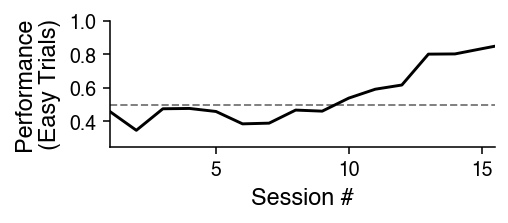

In [17]:
from datetime import date, datetime, timedelta

outData = getMouse('CSHL_003', p=5)
easy_trials = (outData['contrastLeft'] > 0.45).astype(int) | (outData['contrastRight'] > 0.45).astype(int)

perf = []
for d in np.unique(outData['date']):
    date_trials = (outData['date'] == d).astype(int)
    inds = (date_trials * easy_trials).astype(bool)
    perf += [np.average(outData['correct'][inds])]

dates = np.unique([datetime.strptime(i, "%Y-%m-%d") for i in outData['date']])
dates = np.arange(len(dates)) + 1

# Plotting
fig = plt.figure(figsize=(2.75,0.9))

plt.plot(dates[:16], perf[:16], color="black", linewidth=1.5, zorder=2)

plt.axhline(0.5, color="black", linestyle="--", lw=1, alpha=0.5, zorder=0)

plt.xlabel("Session #"); plt.ylabel("Performance\n(Easy Trials)")
plt.xticks(np.arange(0,16,5))
plt.yticks([0.4,0.6,0.8,1.0])
plt.ylim(0.25,1.0)
plt.xlim(1, 15.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 
# plt.savefig(spath + "FigA.pdf")

## Figure B

(20 sec)

In [9]:
# Collect data from manually determined training period
new_dat = psy.trim(outData, END=7000)

# Compute
weights = {'bias' : 0, 'cL' : 1, 'cR' : 1}
K = np.sum([weights[i] for i in weights.keys()])
hyper_guess = {
 'sigma'   : [2**-5]*K,
 'sigInit' : 2**5,
 'sigDay'  : None
  }
optList = ['sigma']

hyp, evd, wMode, hess_info = psy.hyperOpt(new_dat, hyper_guess, weights, optList)

dat = {'hyp' : hyp, 'evd' : evd, 'wMode' : wMode, 'W_std' : hess_info['W_std'],
       'weights' : weights, 'new_dat' : new_dat}

# Save interim result
np.savez_compressed(spath+'figB_data.npz', dat=dat)

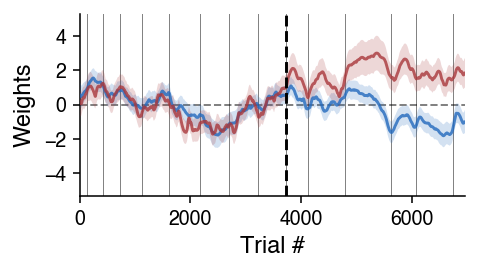

In [15]:
dat = np.load(spath+'figB_data.npz', allow_pickle=True)['dat'].item()

fig = psy.plot_weights(dat['wMode'], dat['weights'], days=dat['new_dat']["dayLength"], 
                       errorbar=dat['W_std'], figsize=(2.75,1.3))

plt.axvline(np.cumsum(dat['new_dat']['dayLength'])[8], c="black", lw=1.5, ls="--", zorder=15)
plt.ylim(-5.3,5.3)
plt.xlim(0, 6950)
plt.yticks([-4,-2,0,2,4])
plt.subplots_adjust(0,0,1,1) 
# plt.savefig(spath + "FigB.pdf")

## Figure C

(30 sec)

In [11]:
BIAS_COLORS = {50 : 'None', 20 : psy.COLORS['sR'], 80 : psy.COLORS['sL']}
def addBiasBlocks(fig, pL):
    plt.sca(fig.gca())
    i = 0
    while i < len(pL):
        start = i
        while i+1 < len(pL) and np.linalg.norm(pL[i] - pL[i+1]) < 0.0001:
            i += 1
        fc = BIAS_COLORS[int(100 * pL[start])]
        plt.axvspan(start, i+1, facecolor=fc, alpha=0.2, edgecolor=None)
        i += 1
    return fig

In [12]:
# Collect data from manually determined training period
outData = getMouse("CSHL_003", 5)

_start  = np.where(outData['date'] >= '2019-04-30')[0][0]
_end    = np.where(outData['date'] >= '2019-05-02')[0][0]
new_dat = psy.trim(outData, START=_start, END=_end)

# Compute
weights = {'bias' : 1, 'cL' : 1, 'cR' : 1}
K = np.sum([weights[i] for i in weights.keys()])
hyper_guess = {
 'sigma'   : [2**-5]*K,
 'sigInit' : 2**5,
 'sigDay'  : [2**-5]*K
  }
optList = ['sigma', 'sigDay']

hyp, evd, wMode, hess_info = psy.hyperOpt(new_dat, hyper_guess, weights, optList)

dat = {'hyp' : hyp, 'evd' : evd, 'wMode' : wMode, 'W_std' : hess_info['W_std'],
       'weights' : weights, 'new_dat' : new_dat}

# Save interim result
np.savez_compressed(spath+'figC_data.npz', dat=dat)

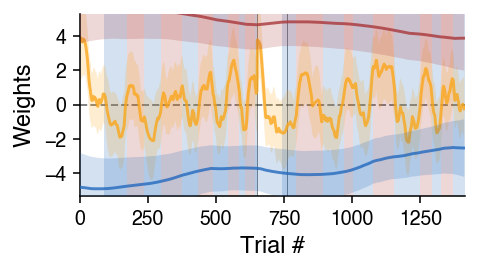

In [16]:
dat = np.load(spath+'figC_data.npz', allow_pickle=True)['dat'].item()

fig = psy.plot_weights(dat['wMode'], dat['weights'], days=dat['new_dat']["dayLength"], 
                       errorbar=dat['W_std'], figsize=(2.75,1.3))
fig = addBiasBlocks(fig, dat['new_dat']['probL'])

plt.gca().set_yticks(np.arange(-6, 7,2))
plt.ylim(-5.3,5.3)

plt.subplots_adjust(0,0,1,1) 
# plt.savefig(spath + "FigC.pdf")